In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import torch

from actioncard import Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch
from aiutils import load, save
from buyagenda import BigMoneyBuyAgenda
from config import GameConfig
from constants import BUY
from enums import StartingSplit
from env import DefaultEnvironment
from player import HeuristicPlayer, load_players, PredictorMLPPlayer
from simulations import simulate

In [3]:
default_kingdom = [Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch]

In [4]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
# logger.setLevel(BUY)

## First-mover advantage ##

In [6]:
import seaborn as sns

In [7]:
config = GameConfig(splits=[StartingSplit.Starting34Split, StartingSplit.Starting34Split], sandbox=True, num_players=2)
players = load_players(['BM', 'BM'], None, map_location='cpu', train=False)
agent = players[0]
env = DefaultEnvironment(config, players, logger=logger)

In [21]:
stats = simulate(env, 10000, None)

100%|██████████| 10000/10000 [02:01<00:00, 82.36it/s]===SUMMARY===
{0: 6786, 1: 5753, 'ProvinceWins': 10000, 'Ties': 2539}



In [19]:
test_stats = simulate(env, 100, None, turn_log=True)

100%|██████████| 100/100 [00:01<00:00, 66.58it/s]===SUMMARY===
{0: 69, 1: 54, 'ProvinceWins': 100, 'Ties': 23}



In [18]:
test_stats.turn_df

,Iter,Player,Score,Card,Turn
0,0,0,3,Silver,0
1,0,1,3,Silver,0
2,0,0,3,Silver,1
3,0,1,3,Silver,1
4,0,0,3,Gold,2
...,...,...,...,...,...
3383,99,0,15,Gold,14
3384,99,1,30,Province,14
3385,99,0,15,Gold,15
3386,99,1,36,Province,15


In [49]:
df = stats.player_df
p0turns, p1turns = df[df['Player'] == 0]['Turns'].reset_index(drop=True), df[df['Player'] == 1]['Turns'].reset_index(drop=True)
diff = p0turns - p1turns
df

,Turns,Player,Score,Won,Iter
0,18,0,36.0,True,1
1,17,1,27.0,False,1
2,17,0,27.0,False,2
3,17,1,33.0,True,2
4,17,0,30.0,True,3
...,...,...,...,...,...
19995,16,1,21.0,False,9998
19996,19,0,34.0,True,9999
19997,19,1,30.0,False,9999
19998,16,0,27.0,True,10000


In [80]:
df['Turns'].max()

27

In [50]:
game_df = stats.game_df
game_df

,MaxScore,ProvinceWin,TimeElapsed,Tie
0,36.0,True,0.013919,False
1,33.0,True,0.010880,False
2,30.0,True,0.010951,False
3,27.0,True,0.012108,True
4,37.0,True,0.009931,False
...,...,...,...,...
9995,33.0,True,0.012607,False
9996,27.0,True,0.011654,True
9997,36.0,True,0.011902,False
9998,34.0,True,0.013466,False


In [48]:
diff.sum() / len(diff)

0.4981

In [52]:
diff.index = diff.index * 2

In [57]:
p0stats = df.iloc[diff.index]
p0stats

,Turns,Player,Score,Won,Iter
0,18,0,36.0,True,1
2,17,0,27.0,False,2
4,17,0,30.0,True,3
6,19,0,27.0,True,4
8,15,0,24.0,False,5
...,...,...,...,...,...
19990,18,0,24.0,False,9996
19992,17,0,27.0,True,9997
19994,17,0,36.0,True,9998
19996,19,0,34.0,True,9999


In [65]:
game_df.index *= 2

In [67]:
game_df 

,MaxScore,ProvinceWin,TimeElapsed,Tie
0,36.0,True,0.013919,False
2,33.0,True,0.010880,False
4,30.0,True,0.010951,False
6,27.0,True,0.012108,True
8,37.0,True,0.009931,False
...,...,...,...,...
19990,33.0,True,0.012607,False
19992,27.0,True,0.011654,True
19994,36.0,True,0.011902,False
19996,34.0,True,0.013466,False


In [79]:
p0advwon = p0stats[(p0stats['Won'] == False) &(diff == 0) & (game_df['Tie'] == False)]
len(p0advwon) / len(diff[diff == 0])

0.43434947200637575

<AxesSubplot:xlabel='Turns'>

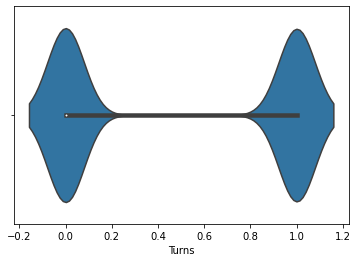

In [44]:
sns.violinplot(x=diff)

In 10k games between BM BM, we have 43.34%/32.12%/24.54% WLT split for random starting split. 43.36%/31.96%/24.68% for 2/5 split. 42.85%/32.18%/24.97% for 3/4 split. Corresponds to starting advantage of 11.22%, 11.4%, 10.67%, resp. 

* Why is the starting advantage 10%? 
* Why does 2/5 not have as large an advantage as 3/4? 

## MLP Simulations ##

In [4]:
model_name = 'r-r-mcts-10k-score'
model_path = os.path.join(model_dir, model_name)
model = torch.load(model_path, map_location='cpu')
model

In [114]:
config = GameConfig(split=StartingSplit.StartingRandomSplit, sandbox=True, num_players=2)
players = load_players(['MLP', 'BM'], [model_path], map_location='cpu', train=False)
agent = players[0]
env = DefaultEnvironment(config, players, logger=logger)

In [117]:
simulate(env, 1, None)

  0%|          | 0/1 [00:00<?, ?it/s]BUY:root:Player 0, Turn 0: Estate
BUY:root:Player 1, Turn 1: Silver
BUY:root:Player 0, Turn 1: Estate
BUY:root:Player 1, Turn 2: Silver
BUY:root:Player 0, Turn 2: Estate
BUY:root:Player 1, Turn 3: Gold
BUY:root:Player 0, Turn 3: Estate
BUY:root:Player 1, Turn 4: Silver
BUY:root:Player 0, Turn 4: Estate
BUY:root:Player 1, Turn 5: Silver
BUY:root:Player 0, Turn 5: None
BUY:root:Player 1, Turn 6: Gold
BUY:root:Player 0, Turn 6: Estate
BUY:root:Player 1, Turn 7: Gold
BUY:root:Player 0, Turn 7: Copper
BUY:root:Player 1, Turn 8: Gold
BUY:root:Player 0, Turn 8: Estate
BUY:root:Player 1, Turn 9: Silver
BUY:root:Player 0, Turn 9: Estate
BUY:root:Player 1, Turn 10: Silver
BUY:root:Player 0, Turn 10: Copper
BUY:root:Player 1, Turn 11: Province
BUY:root:Player 0, Turn 11: Copper
BUY:root:Player 1, Turn 12: Gold
BUY:root:Player 0, Turn 12: Silver
BUY:root:Player 1, Turn 13: Province
BUY:root:Player 0, Turn 13: Copper
BUY:root:Player 1, Turn 14: Gold
BUY:root:Pla

Let's analyze the neural network outputs for some simple cases.

In [20]:
from state import ReducedStateFeature

In [21]:
skip = ReducedStateFeature.default_sandbox_feature()
copper = ReducedStateFeature.default_sandbox_feature()
silver = ReducedStateFeature.default_sandbox_feature()
estate = ReducedStateFeature.default_sandbox_feature()

In [22]:
copper[0] = 45
copper[7] = 8
copper

tensor([45., 10.,  8.,  8.,  8., 40., 30.,  8.,  0.,  3.,  0.,  0.,  0.,  0.,
         7.,  0.,  3.,  0.,  0.,  0.,  0.])

In [23]:
silver[5] = 39
silver[7+5] = 1
silver

tensor([46., 10.,  8.,  8.,  8., 39., 30.,  7.,  0.,  3.,  0.,  0.,  1.,  0.,
         7.,  0.,  3.,  0.,  0.,  0.,  0.])

In [24]:
estate[2] = 7
estate[7+2] = 4
estate

tensor([46., 10.,  7.,  8.,  8., 40., 30.,  7.,  0.,  4.,  0.,  0.,  0.,  0.,
         7.,  0.,  3.,  0.,  0.,  0.,  0.])

In [54]:
agent.model(copper), agent.model(silver), agent.model(estate)

TypeError: 'LogisticRegression' object is not callable

## Tree Simulations ##

In [5]:
from mcts import GameTree

In [22]:
tree_name = 'default-r-r-mcts'
tree_path = os.path.join(model_dir, tree_name)
rollout_name = 'default-mlog'
rollout_path = os.path.join(model_dir, rollout_name)

In [10]:
tree_name = 'r-r-mcts-bm-100k-srat-base-default-ucb1-cdecay'
rollout_name = 'mlog-10k-base-default-bm'
tree_path = os.path.join(model_dir, tree_name)
rollout_path = os.path.join(model_dir, rollout_name)

In [11]:
tree = GameTree.load(tree_path, train=False, _skip_level=False, selection='max')

In [42]:
tree.selection = 'secure'
tree.selection

'secure'

In [121]:
tree._root.children[2].children[6].children[14]

Parent: Militia << (n: 1877, v: 1269.0, Q: 0.676 c: Witch) >> Children: [(0, 'Copper', '141', '0.177'), (1, 'Estate', '80', '0.025'), (2, 'Silver', '310', '0.329'), (3, 'Chapel', '503', '0.397'), (4, 'Moat', '538', '0.404'), (5, 'Village', '143', '0.199'), (6, 'None', '161', '0.208')]

In [12]:
# config = GameConfig(splits=[StartingSplit.Starting25Split, StartingSplit.Starting25Split], sandbox=True, num_players=2)
# splits = [StartingSplit.Starting25Split, StartingSplit.Starting25Split]
splits = [StartingSplit.StartingRandomSplit, StartingSplit.StartingRandomSplit]
config = GameConfig(splits=splits, sandbox=False, num_players=2, must_include=default_kingdom)
players = load_players(['UCT', 'DW'], [rollout_path], tree=tree, train=False, rollout_type='mlog', use_tree=True)
# agent = load_players(['UCT'], [rollout_path], tree=tree, train=False, rollout_type='mlog', use_tree=False)[0]
# players = [agent, agent]
env = DefaultEnvironment(config, players, logger=logger)

In [21]:
logger.setLevel(logging.ERROR)
# logger.setLevel(BUY)

In [23]:
sim_data = simulate(env, 1000, tree)

100%|██████████| 1000/1000 [00:24<00:00, 40.35it/s]===SUMMARY===
{0: 593, 1: 437, 'ProvinceWins': 994, 'Ties': 30}



In [12]:
sim_data.game_df

,MaxScore,ProvinceWin,TimeElapsed,Tie
0,40.0,True,0.06635,False


In [97]:
data_dir = os.path.join(project_root, 'data')
data_name ='bm25-bm25-10k-scores'
data_path = os.path.join(data_dir, data_name)

In [98]:
save(data_path, sim_data.player_df)